Here I'm gonna use different methods to find out the correlations in my data base.

Loading Data And Initial Imports

In [11]:
import os
os.environ['SCIPY_ARRAY_API'] = '1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
loan = pd.read_csv("../data/input/loan.csv")

Getting basics information. 

In [13]:
loan.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [14]:
df_loan = loan.copy() # DataFrame for processed data

Visualized Methods:

1. Scatter Plot: for two numerical variables.
2. Heatmap: for many numerical variables.
3. Box Plot / Violin Plot: for comparing numerical plots across the different groups of categorical variables.

Types of my variables:

Numeric: ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History

Categorical (Nominal): Gender, Married, Education, Self_Employed, Property_Area, Loan_Status

Categorical (Ordinal) or Numeric (Discrete): Dependents 


Income influences loan size, but only slightly—every 50% increase in applicant income raises loan amount.


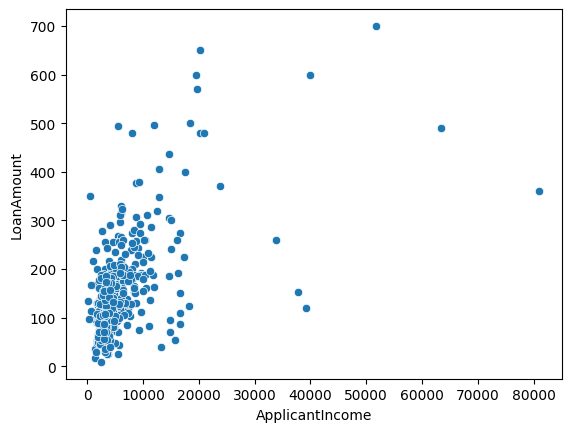

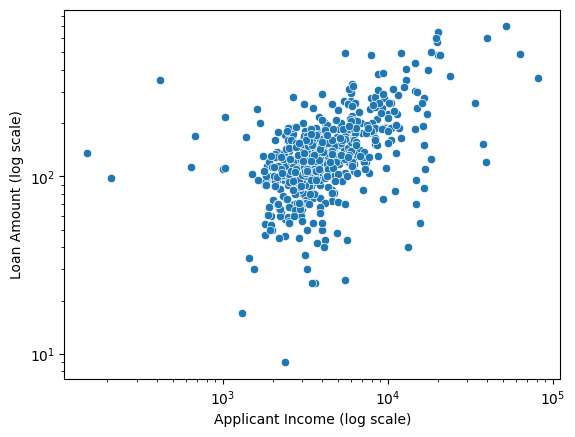

In [34]:
# Scatter Plot

sns.scatterplot(data=df_loan, x='ApplicantIncome', y='LoanAmount')
plt.savefig('../data/output/scatter_plot_applicant_income_loan_amount.png')
print("\nIncome influences loan size, but only slightly—every 50% increase in applicant income raises loan amount.")
plt.show()

# The plot would benefit from a log₁₀ transform on the x-axis since the majority of income values are 
# compressed below 30 k, but the axis runs to 80 k:

sns.scatterplot(data=df_loan, x='ApplicantIncome', y='LoanAmount')
plt.xscale('log')     
plt.yscale('log')     
plt.xlabel('Applicant Income (log scale)')
plt.ylabel('Loan Amount (log scale)')
plt.savefig('../data/output/scatter_plot_applicant_income_loan_amount_log.png')
plt.show()

# The funnel-shaped cloud on this log-log scatter plot straightens into a tight diagonal band, 
# exposing a clear 50% proportional increase in loan amount for each doubling of income. 
# This was obscured by a dense, unreadable blob on the original linear scatter plot.

Chi2_Contingency:

Helps us to determine whether there is a statistifically significant association between to categorical variables.

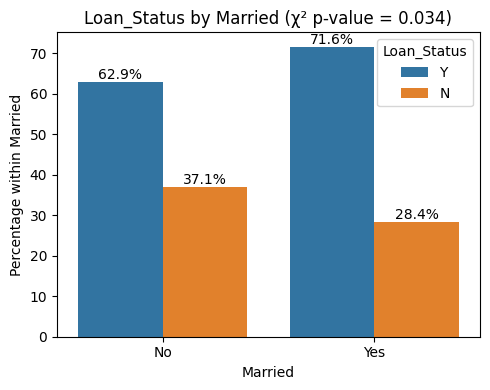

Married and Loan_Status have a statistically significant association.


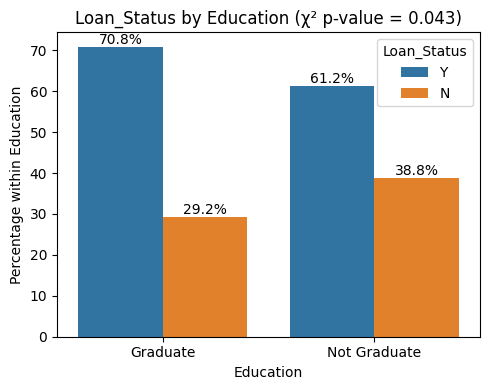

Education and Loan_Status have a statistically significant association.


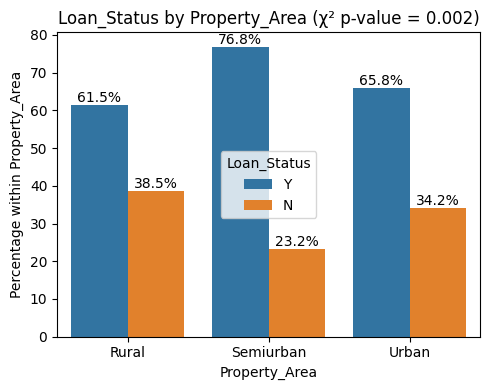

Property_Area and Loan_Status have a statistically significant association.


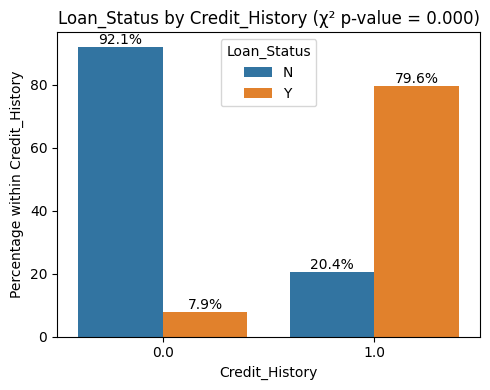

Credit_History and Loan_Status have a statistically significant association.


In [16]:
from scipy.stats import chi2_contingency

def plot_chi2_summary(df_original, feature_col, target_col='Loan_Status'):
  
    cols = [feature_col, target_col]
    df = df_original[cols].dropna()

    ct = pd.crosstab(df[feature_col], df[target_col])
    chi2, p, dof, exp = chi2_contingency(ct)

 
    temp = (
        df.groupby(feature_col)[target_col]
          .value_counts(normalize=True)
          .mul(100)
          .rename('Percent')
          .reset_index()
    )


    plt.figure(figsize=(5, 4))
    ax = sns.barplot(data=temp, x=feature_col, y='Percent', hue=target_col)


    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f%%')
    
    ax.set_title(f'{target_col} by {feature_col} (χ² p-value = {p:.3f})')
    ax.set_ylabel(f'Percentage within {feature_col}')
    plt.tight_layout()
    plt.show()

    if p < 0.05:
        print(f"{feature_col} and {target_col} have a statistically significant association.")
    else:
        print(f"No statistically significant association found between {feature_col} and {target_col}.")


plot_chi2_summary(loan, 'Married')
plot_chi2_summary(loan, 'Education')
plot_chi2_summary(loan, 'Property_Area')
plot_chi2_summary(loan, 'Credit_History')